
# Suspicious Web Threat Interactions — EDA & Modeling

This notebook walks through:
1) Loading & cleaning the CloudWatch web traffic dataset
2) Feature engineering
3) Exploratory analysis (plots)
4) **Anomaly detection** with IsolationForest
5) **(Optional)** Supervised baseline (RandomForest) if labels are usable
6) SQLite & Excel exports for stakeholder analysis


In [2]:

# Imports
import os, sys, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Make plots a bit larger
plt.rcParams["figure.figsize"] = (10, 6)

DATA_PATH = Path("..") / "data" / "CloudWatch_Traffic_Web_Attack.csv"
ARTIFACTS = Path("..") / "artifacts"
ARTIFACTS.mkdir(parents=True, exist_ok=True)

# Helper to save figures
def savefig(name):
    p = ARTIFACTS / name
    plt.tight_layout()
    plt.savefig(p, dpi=150, bbox_inches="tight")
    print("Saved:", p)


In [3]:

# Load
assert DATA_PATH.exists(), f"Dataset not found at {DATA_PATH}. Pla."
df = pd.read_csv(DATA_PATH)
print(df.shape)
display(df.head())
display(df.describe(include='all'))


(282, 16)


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
count,2.820000e+02,2.820000e+02,282,282,282,282,282,282.0,282.0,282,282,282,282,282,282,282
unique,NaN,NaN,30,30,28,7,1,NaN,NaN,1,1,1,1,1,30,1
top,NaN,NaN,2024-04-26T09:00:00Z,2024-04-26T09:10:00Z,165.225.209.4,US,HTTPS,NaN,NaN,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T09:00:00Z,waf_rule
freq,NaN,NaN,17,17,29,113,282,NaN,NaN,282,282,282,282,282,17,282
mean,1.199390e+06,8.455429e+04,NaN,NaN,NaN,NaN,NaN,200.0,443.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.149312e+06,2.549279e+05,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,4.000000e+01,4.400000e+01,NaN,NaN,NaN,NaN,NaN,200.0,443.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,5.381500e+03,1.114200e+04,NaN,NaN,NaN,NaN,NaN,200.0,443.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.318200e+04,1.379950e+04,NaN,NaN,NaN,NaN,NaN,200.0,443.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.083300e+04,2.627950e+04,NaN,NaN,NaN,NaN,NaN,200.0,443.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:

# Datetime typing & basic cleaning
for col in ["creation_time","end_time","time"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# Guard: ensure response code numeric if present
if "response.code" in df.columns:
    df["response.code"] = pd.to_numeric(df["response.code"], errors="coerce")

# Drop full-NA rows
df = df.dropna(how="all").copy()

# Basic info
display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object             
 12  source.meta          2

None

In [2]:

import pandas as pd
from pathlib import Path

# Path to your CSV
DATA_PATH = Path("..") / "data" / "CloudWatch_Traffic_Web_Attack.csv"

# Load dataset
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()


Shape: (282, 16)


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


Saved: ..\artifacts\hist_bytes.png


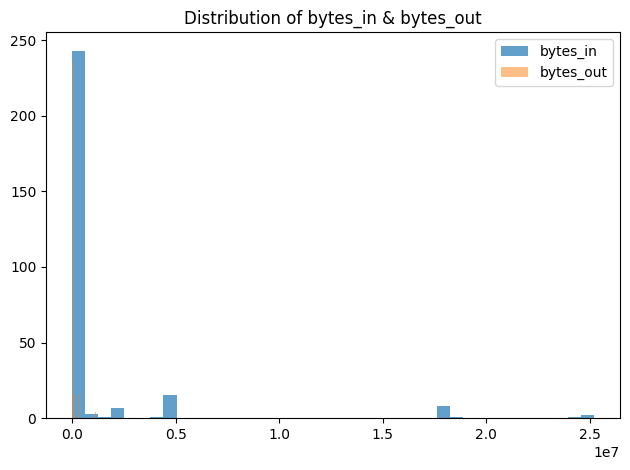

In [5]:

# EDA: distributions (matplotlib only)
import matplotlib.pyplot as plt
ARTIFACTS = Path("..") / "artifacts"
ARTIFACTS.mkdir(parents=True, exist_ok=True)

# Helper to save figures
def savefig(name):
    p = ARTIFACTS / name
    plt.tight_layout()
    plt.savefig(p, dpi=150, bbox_inches="tight")
    print("Saved:", p)

fig = plt.figure()
plt.hist(df["bytes_in"].dropna(), bins=40, alpha=0.7, label="bytes_in")
plt.hist(df["bytes_out"].dropna(), bins=40, alpha=0.5, label="bytes_out")
plt.title("Distribution of bytes_in & bytes_out")
plt.legend()
savefig("hist_bytes.png")
plt.show()


Saved: ..\artifacts\bar_protocol.png


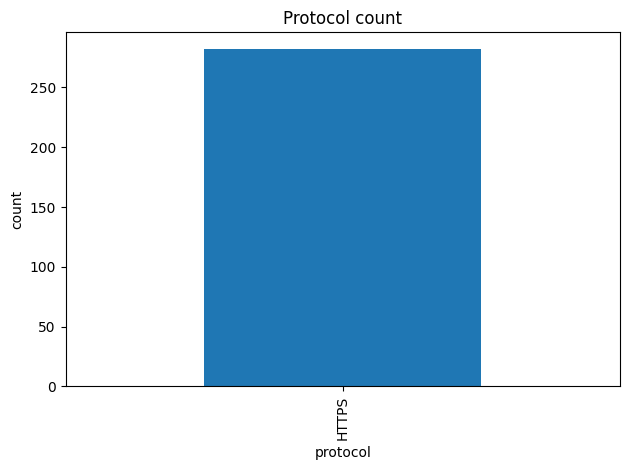

In [6]:

# EDA: protocol counts
if "protocol" in df.columns:
    counts = df["protocol"].value_counts().sort_index()
    fig = plt.figure()
    counts.plot(kind="bar")
    plt.title("Protocol count")
    plt.xlabel("protocol")
    plt.ylabel("count")
    savefig("bar_protocol.png")
    plt.show()


Saved: ..\artifacts\barh_country.png


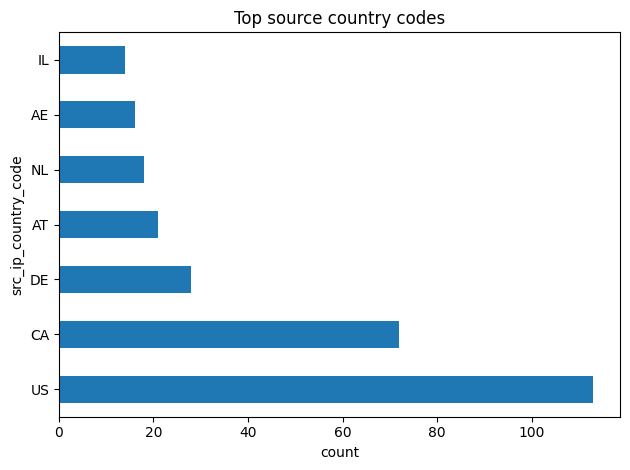

In [7]:

# EDA: country code
if "src_ip_country_code" in df.columns:
    cc = df["src_ip_country_code"].astype(str).str.upper().value_counts().head(15)
    fig = plt.figure()
    cc.plot(kind="barh")
    plt.title("Top source country codes")
    plt.xlabel("count")
    savefig("barh_country.png")
    plt.show()


anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64

Saved: ..\artifacts\scatter_anomaly.png


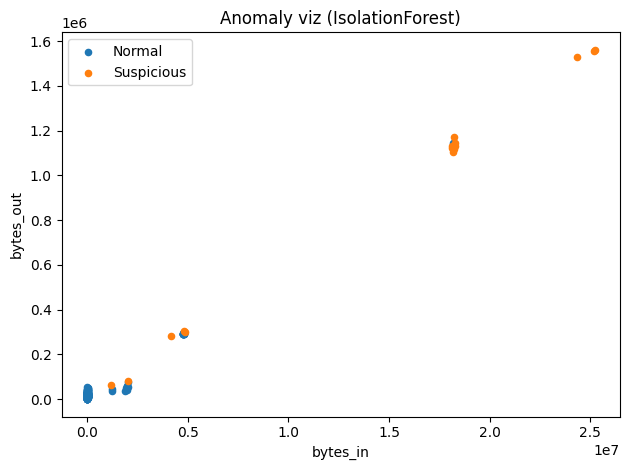

In [11]:
import numpy as np


# IsolationForest anomaly detection
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

feat_cols = [c for c in ["bytes_in","bytes_out","session_duration","avg_packet_size"] if c in df.columns]
X = df[feat_cols].replace([np.inf, -np.inf], np.nan).dropna()
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
model = IsolationForest(contamination=0.05, random_state=42)
preds = model.fit_predict(Xs)
df_anom = df.loc[X.index].copy()
df_anom["anomaly"] = np.where(preds==-1, "Suspicious","Normal")
display(df_anom["anomaly"].value_counts())

# Simple scatter to visualize (bytes_in vs bytes_out)
fig = plt.figure()
normal = df_anom[df_anom["anomaly"]=="Normal"]
susp = df_anom[df_anom["anomaly"]=="Suspicious"]
plt.scatter(normal["bytes_in"], normal["bytes_out"], s=20, label="Normal")
plt.scatter(susp["bytes_in"], susp["bytes_out"], s=20, label="Suspicious")
plt.xlabel("bytes_in"); plt.ylabel("bytes_out"); plt.title("Anomaly viz (IsolationForest)")
plt.legend()
savefig("scatter_anomaly.png")
plt.show()

# Save
df_anom.to_parquet(ARTIFACTS / "anomaly_scored.parquet", index=False)


Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85

Saved: ..\artifacts\feature_importance.png


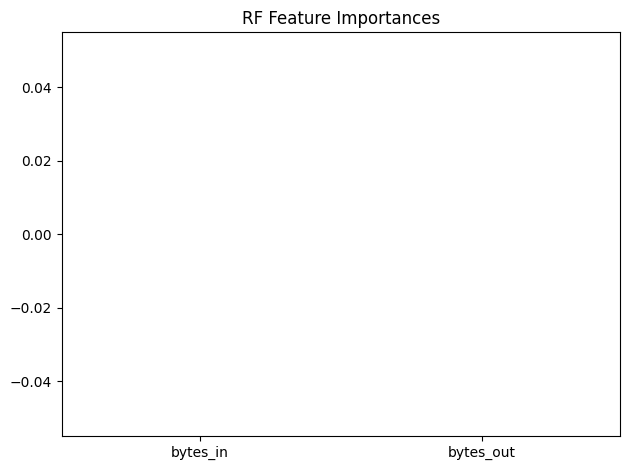

In [12]:

# Optional: supervised baseline if labels look usable
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import joblib

# Construct a simple label from detection_types if present
if "detection_types" in df.columns:
    s = df["detection_types"].astype(str).str.lower()
    y = s.str.contains("waf|attack|suspici|anomal", regex=True).fillna(False).astype(int)

    feat_cols = [c for c in ["bytes_in","bytes_out","session_duration","avg_packet_size"] if c in df.columns]
    X = df[feat_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=42, stratify=y)

    rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced")
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Feature importances
    importances = rf.feature_importances_
    fig = plt.figure()
    plt.bar(range(len(feat_cols)), importances, tick_label=feat_cols)
    plt.title("RF Feature Importances")
    savefig("feature_importance.png")
    plt.show()

    # Save artifacts
    joblib.dump(rf, ARTIFACTS / "rf_model.joblib")
    joblib.dump(scaler, ARTIFACTS / "rf_scaler.joblib")


In [14]:

# Create SQLite DB and run sample queries
import sqlite3
from pathlib import Path

DB_PATH = Path("..") / "data" / "web_threats.sqlite"
con = sqlite3.connect(DB_PATH)
# standardize names to simple SQL-friendly columns
tmp = df.rename(columns={
    "response.code":"response_code",
    "source.meta":"source_meta",
    "source.name":"source_name"
}).copy()
tmp.to_sql("web_traffic", con, if_exists="replace", index=False)
print("Rows inserted:", tmp.shape[0])

# Example query: top talkers by bytes_in
q = "SELECT src_ip, SUM(bytes_in) AS total_in FROM web_traffic GROUP BY src_ip ORDER BY total_in DESC LIMIT 10;"
top_talkers = pd.read_sql(q, con)
display(top_talkers.head())

con.close()


Rows inserted: 282


,src_ip,total_in
0,155.91.45.242,314710879
1,165.225.240.79,19639612
2,136.226.67.101,664597
3,136.226.64.114,579830
4,165.225.212.255,484106


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
DATA_PATH = Path("..") / "data" / "CloudWatch_Traffic_Web_Attack.csv"
ARTIFACTS = Path("..") / "artifacts"
REPORTS = Path("..") / "reports"

# Create folders
ARTIFACTS.mkdir(parents=True, exist_ok=True)
REPORTS.mkdir(parents=True, exist_ok=True)

print("Setup complete")
# Load dataset
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()
# Example: Export Excel aggregates
out_xlsx = REPORTS / "aggregates.xlsx"

with pd.ExcelWriter(out_xlsx) as writer:
    by_country = df.groupby("src_ip_country_code", dropna=False)[["bytes_in","bytes_out"]] \
                   .sum().sort_values("bytes_in", ascending=False)
    by_country.to_excel(writer, sheet_name="by_country")

print("Excel report saved at:", out_xlsx.resolve())



Setup complete
Dataset shape: (282, 16)
Excel report saved at: C:\Users\USER\OneDrive\Desktop\Cybersecurity_suspicius_web_Threat\reports\aggregates.xlsx
